# Crowd Tangle LDA Evaluation Workflow 

## 1. Import text and stop words

In [1]:
import os
import pandas as pd
from util import read_crowdtangle_files, create_corpus
import time
from datetime import timedelta
from pprint import pprint
from gensim.models.wrappers import LdaMallet
import pickle
from gensim.corpora.mmcorpus import MmCorpus

#Specify path to input and output directories
input_dir = '/Users/dankoban/Documents/EM6575/LDAInput'
output_dir = '/Users/dankoban/Documents/EM6575/LDAOutput'

In [2]:
# Extract file names from input directory
files = [file for file in os.listdir(input_dir) if file.endswith(".csv")]   
file_paths = [input_dir + "/" + file for file in files]

# Select only n files for testing
file_paths = file_paths[0:2]

start_time = time.time()
df = read_crowdtangle_files(file_paths)
print("--- %s time elapsed ---" % str(timedelta(seconds=time.time() - start_time)))

100%|██████████| 2/2 [00:05<00:00,  2.88s/it]

--- 0:00:05.763399 time elapsed ---


In [3]:
# Extract subset of total data for testing the workflow
pd.set_option('display.max_colwidth', None)
df = pd.concat(df)
#df = df.head(1000)
print(len(df))
df.head()

264261


,Facebook Id,Text
0,624614494274945,"Nika Vetsko, excerpts: ...Many researchers believe that Russia is trying to increase this traffic in Georgia, having already been active in fuelling anti-vaccination conspiracy theories. Some link this directly to the country’s measles outbreak last year. ...Russia has also revived conspiracy theories around the Lugar Laboratory, a US fi ced high-tech research centre in Tbilisi. Over the years, Russian authorities and media have worked to discredit the lab and US-Georgia relations more widely. Is Russia Exploiting Coronavirus Fears In Georgia? By Nika Vetsko* Experts warn that Russia is exploiting the recent appearance of coronavirus in Georgia to spread a new wave of disinformation and conspiracy theories. Georgia has registered only 15…"
1,26781952138,"The capital’s first Covid-19 patient, a 45-year-old man from Mayur Vihar Phase II, has recovered fully from the viral infection. He was discharged from Ram Manohar Lohia Hospital on Saturday, said a source. Delhi’s first coronavirus patient recovers fully The capital’s first Covid-19 patient, a 45-year-old man from Mayur Vihar Phase II, has recovered fully from the viral infection. He was discharged fro"
2,251907774312,"The coronavirus pandemic is yet to force widespread school shutdowns but many families are voluntarily withdrawing their children. 'I'm happy to be a small drop': Families withdrawing children from school to fight coronavirus The coronavirus pandemic is yet to force widespread school shutdowns but across Sydney, many families are voluntarily withdrawing their children."
3,138280549589759,"The safety and well-being of our community and the Brothers Fish&chips family is always the top priority. In challenging times like this, we are faced with many uncertainties. However, one thing that is certain is that together as a community we will overcome this situation and we’d like to reassure that we are following CDC recommended guidelines regarding coronavirus, COVID-19 to keep you and our family safe as much as we can! #ossining #croton #briarcliff #westchester #lohudfood We are temporarily offering prepaid delivery and curb side pick-up. Call (914) 488-5141 to place your order and before arrival. Timeline Photos"
4,32204506174,"With the coronavirus spreading across the globe @carynceolin with how the White House is trying to prevent it from spreading around the West Wing. Trump tested negative for COVID-19 - CityNews Toronto As the coronavirus inches closer to President Trump, Caryn Ceolin with how the White House is trying to prevent it from spreading around the West Wing."


In [4]:
# Import custom list of stop words
stop_words = pd.read_csv("/Users/dankoban/Documents/lda_evaluation/data/new_stopwords.csv")
stop_words = stop_words['stop_word'].tolist()
stop_words[0:5]

['a', 'able', 'about', 'above', 'according']

## 2. Generate a corpus and dictionary

In [5]:
[dictionary, corpus] = create_corpus(text = df.Text, stop_words = stop_words)

/Users/dankoban/Documents/workspace/python/venvs/forcenexus/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['don', 'dont', 'hey', 'ive', 'lets', 'weve', 'yall', 'youd', 'youre'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Number of unique tokens: 352668
Number of documents: 264261


In [6]:
# Save dictionary and corpus to disc
dictionary.save(output_dir + "/dictionary.pkl")
MmCorpus.serialize(output_dir + "/corpus.pkl", corpus)

## 3. Fit an LDA model using gensim LdaMallet 

Fit a new model

In [7]:
os.environ.update({'MALLET_HOME':r'/Users/dankoban/mallet-2.0.8/'})

start_time = time.time()
lda = LdaMallet(mallet_path = '/Users/dankoban/mallet-2.0.8/bin/mallet', 
                corpus=corpus, num_topics=50, id2word=dictionary, 
                workers = 20, iterations = 500, random_seed = 1)

print("--- %s time elapsed ---" % str(timedelta(seconds=time.time() - start_time)))

--- 0:06:25.035359 time elapsed ---


In [8]:
# Save model to disk
pickle.dump(lda, open(output_dir + "/mallet.pkl", "wb"))

## ** Save point.  If a model is already fit, start here and continue on for follow on evaluation **

Load an existing model.  If an existing model doesn't exist, execute the code to fit a new model

In [9]:
lda = pickle.load(open(output_dir + "/mallet.pkl", "rb"))
dictionary = pickle.load(open(output_dir + "/dictionary.pkl", "rb"))
corpus = MmCorpus(open(output_dir + "/corpus.pkl", "rb"))

# Show Topics
pprint(lda.show_topic(1))

[('trump', 0.18414082200634324),
 ('president', 0.12638724236279167),
 ('national', 0.055199220076140615),
 ('donald', 0.04881241342500223),
 ('house', 0.0421859653645545),
 ('white', 0.03655983864145106),
 ('tested', 0.035301721242577015),
 ('negative', 0.025004402503163447),
 ('test', 0.019741368824468114),
 ('administration', 0.01884089807433604)]


## 4. Reorganize topics into a readable format

In [10]:
tm_results = lda[corpus]
corpus_topics = [sorted(topics, 
                        key=lambda record: -record[1])[0] for topics in tm_results]

topics = [[(term, round(wt, 3)) for term, wt in lda.show_topic(n, topn=20)] 
                                for n in range(0, lda.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], 
                           columns = ['Term'+str(i) for i in range(1, 21)], 
                           index=['Topic '+str(t) for t in range(1, lda.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50
Term1,continue,trump,read,emergency,spread,media,april,set,outbreak,wednesday,...,news,crisis,cases,care,food,social,community,government,don,god
Term2,safety,president,full,response,virus,related,today,general,amid,daily,...,live,plan,positive,workers,hours,medical,online,minister,good,love
Term3,staff,national,paper,bill,prevent,area,questions,hand,force,data,...,week,american,confirmed,work,stores,patients,university,advice,system,fear
Term4,situation,donald,story,leave,stop,list,live,central,press,san,...,tests,action,number,long,store,hospital,members,chief,coming,hope
Term5,taking,house,toilet,house,family,report,join,illinois,conference,morning,...,island,change,deaths,employees,delivery,distancing,link,prime,weeks,prayer
Term6,ensure,white,panic,act,slow,reports,special,sanitizer,task,massachusetts,...,watch,leaders,tested,working,grocery,patient,classes,michigan,years,pray
Term7,team,tested,twitter,federal,canada,growing,meeting,light,texas,normal,...,america,reopen,death,california,supplies,hospitals,college,australia,things,message
Term8,customers,negative,east,provide,corona,calls,virtual,step,hold,numbers,...,top,unprecedented,case,term,essential,woman,board,officer,protective,time
Term9,safe,test,isolation,aid,measures,sign,thursday,price,briefing,head,...,staff,threat,total,pay,items,died,click,jersey,personal,jesus
Term10,members,administration,nigeria,paid,ongoing,black,town,rest,hits,begin,...,breaking,challenges,reported,unemployment,apple,doctors,member,murphy,lot,lord


In [11]:
# set column width
pd.set_option('display.max_colwidth', None)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, lda.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"continue, safety, staff, situation, taking, ensure, team, customers, safe, members, community, measures, precautions, priority, time, employees, monitoring, monitor, steps, closely"
Topic2,"trump, president, national, donald, house, white, tested, negative, test, administration, washington, friday, declared, results, saturday, tests, vice, mike, night, press"
Topic3,"read, full, paper, story, toilet, panic, twitter, east, isolation, nigeria, article, centre, colorado, shortage, words, lagos, opening, post, london, region"
Topic4,"emergency, response, bill, leave, house, act, federal, provide, aid, paid, sick, relief, passed, package, congress, families, legislation, americans, free, democrats"
Topic5,"spread, virus, prevent, stop, family, slow, canada, corona, measures, ongoing, limit, protect, preparing, reduce, amidst, effort, revealed, movie, part, trip"
Topic6,"media, related, area, list, report, reports, growing, calls, sign, black, received, bay, fake, cancellations, calling, warning, scams, curve, true, alert"
Topic7,"april, today, questions, live, join, special, meeting, virtual, thursday, town, hall, discuss, biden, joe, answer, tonight, facebook, answers, asked, sanders"
Topic8,"set, general, hand, central, illinois, sanitizer, light, step, price, rest, bring, allowed, amazon, southern, free, party, attorney, sell, gouging, risks"
Topic9,"outbreak, amid, force, press, conference, task, texas, hold, briefing, hits, prevention, carey, teach, holds, mariah, classic, giant, abbott, fights, drastic"
Topic10,"wednesday, daily, data, san, morning, massachusetts, normal, numbers, head, begin, infection, takes, reopening, maryland, spreads, cities, major, peak, wide, military"


## 5. Visualize topics with a clustermap

In [12]:
from collections import OrderedDict
data_lda = {i: OrderedDict(lda.show_topic(i,5)) for i in range(50)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(50, 241)


/Users/dankoban/Documents/workspace/python/venvs/forcenexus/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


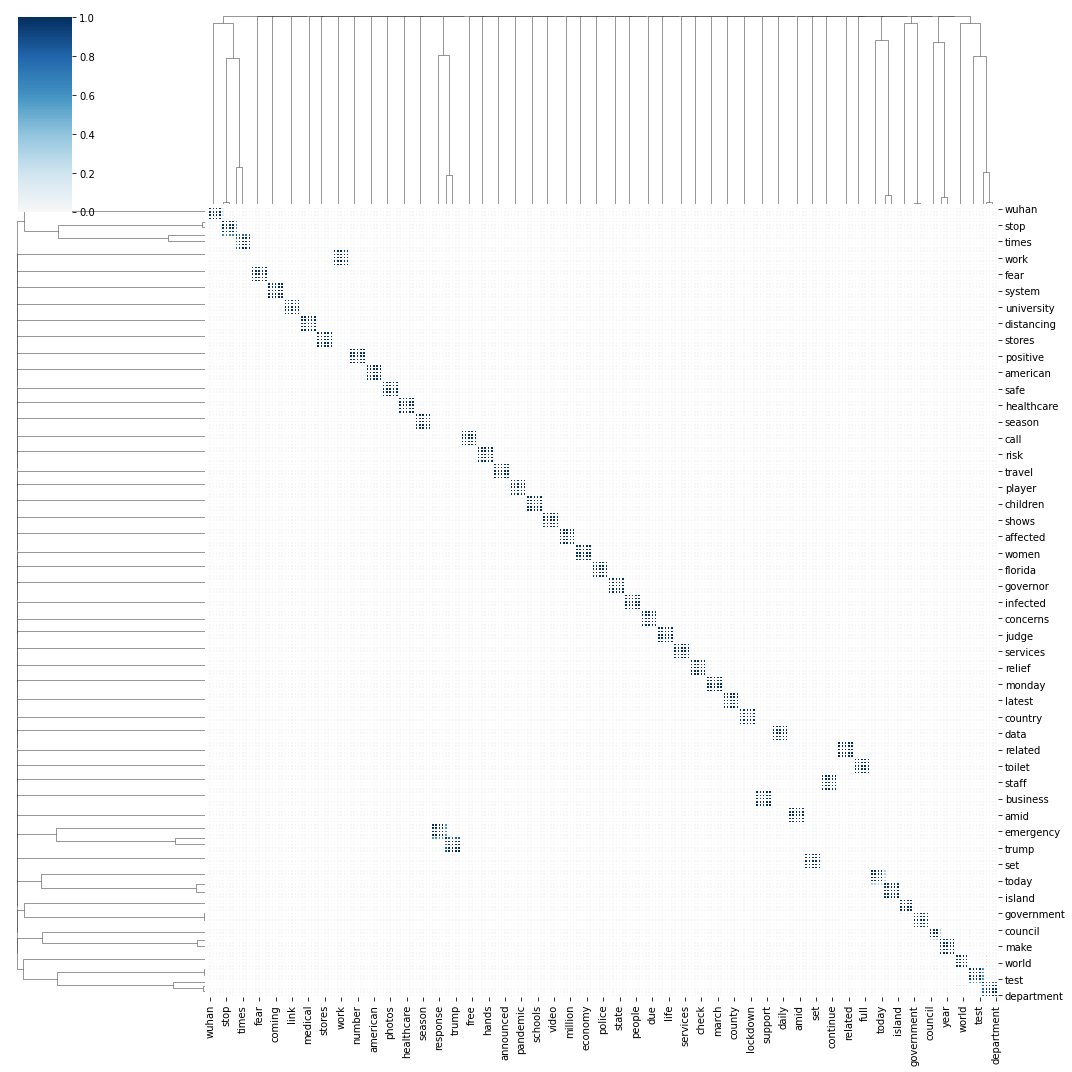

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, 
                 cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()